# Data Transform

In this notebook, we will ask you a series of questions to evaluate your findings from your EDA. Based on your response & justification, we will ask you to also apply a subsequent data transformation. 

If you state that you will not apply any data transformations for this step, you must **justify** as to why your dataset/machine-learning does not require the mentioned data preprocessing step.

The bonus step is completely optional, but if you provide a sufficient feature engineering step in this project we will add `1000` points to your Kahoot leaderboard score.

You will write out this transformed dataframe as a `.csv` file to your `data/` folder.

**Note**: Again, note that this dataset is quite large. If you find that some data operations take too long to complete on your machine, simply use the `sample()` method to transform a subset of your data.

# Data Transformation – Fraud Detection

This notebook prepares the 1 million bank transaction dataset for modeling by cleaning, transforming, and engineering features. The goal is to create a processed version of the dataset that addresses skewness, class imbalance, and feature representation issues identified during the exploratory analysis.

## Objectives:
- **Clean and standardize** the dataset by addressing any nulls, duplicates, or irrelevant columns.
- **Transform numeric features** to reduce skew and improve suitability for modeling (e.g., scaling or logarithmic transformations).
- **Encode categorical variables** so they can be used in machine learning models.
- **Handle class imbalance** to ensure the fraud class is represented fairly (e.g., via oversampling, undersampling, or SMOTE).
- **Engineer new features** based on patterns identified in the EDA phase to strengthen model performance.

## Notebook Structure:
1. **Q1** – Data Cleaning and Standardization  
2. **Q2** – Feature Transformation and Encoding  
3. **Q3** – Handling Class Imbalance and Feature Engineering  
4. **Bonus (Optional)** – Additional feature creation or optimizations  
5. **Export** – Save the transformed dataset for use in the `model_train.ipynb` notebook


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import os

## Q1
The first step in preparing the dataset for modeling is to confirm whether it contains any **missing values** or **non-predictive columns**.  
- Missing values can distort analysis and must be handled (e.g., imputation or removal).  
- Non-predictive columns, such as unique identifiers or metadata, can add noise and reduce model performance if not removed.  

This step will examine the dataset for these issues and apply any necessary cleaning or transformations to ensure the final dataset is ready for feature engineering and modeling.

This addresses the following question, 

    Does your model contain any missing values or "non-predictive" columns? If so, which adjustments should you take to ensure that your model has good predictive capabilities? Apply your data transformations (if any) in the code-block below.

## Load Data 

In [77]:
# Load the dataset (update the path if needed)
transactions = pd.read_csv("../data/bank_transactions.csv")

## Data Cleaning and Standardization 

In [78]:
# Check for missing values

transactions.isnull().sum()

type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**Interpretation:** No missing values detected.

In [79]:
# Identify non-predictive columns automatically

non_predictive_cols = []

for col in transactions.columns:
    unique_count = transactions[col].nunique()
    
    # If the column is completely unique (like a row ID) or constant
    if unique_count == transactions.shape[0] or unique_count == 1:
        non_predictive_cols.append(col)
        
    # If the column is mostly unique (like IDs with >90% unique values)
    elif unique_count / transactions.shape[0] > 0.9:
        non_predictive_cols.append(col)

print("Potential Non-Predictive Columns (Auto-Detected):", non_predictive_cols if non_predictive_cols else "No obvious non-predictive columns detected.")


Potential Non-Predictive Columns (Auto-Detected): ['amount', 'nameOrig']


In [80]:
# Identify potential non-predictive columns (ignore continuous numeric features)
non_predictive_cols = []

for col in transactions.columns:
    unique_count = transactions[col].nunique()
    
    # Skip continuous numeric columns when checking high uniqueness
    if pd.api.types.is_numeric_dtype(transactions[col]) and unique_count > 100:  
        continue  # don't flag as non-predictive just for having many values
    
    # Flag columns that are either IDs, constant, or mostly unique (for non-numeric types)
    if unique_count == transactions.shape[0] or unique_count == 1:
        non_predictive_cols.append(col)
    elif unique_count / transactions.shape[0] > 0.9:
        non_predictive_cols.append(col)

print("Potential Non-Predictive Columns (Auto-Detected):", non_predictive_cols if non_predictive_cols else "No obvious non-predictive columns detected.")


Potential Non-Predictive Columns (Auto-Detected): ['nameOrig']


**Interpretation:** The automated detection flagged two columns as potentially non-predictive:

- **`amount`** - Flagged only because it has many unique values, but this is expected for a continuous numeric feature. It is a key predictor and will be **kept** for modeling.
- **`nameOrig`** – Behaves like a unique identifier, with nearly every row distinct. It adds no predictive value and will be **removed** from the dataset.

Only `nameOrig` will be dropped before modeling.

*Note:* The detection logic was adjusted so that **continuous numeric features** (like `amount`) are not flagged as non-predictive simply because they have many unique values.  
High uniqueness is expected for numeric features and does not make them IDs or useless for modeling.  

With this adjustment:
- **`amount`** is correctly retained as a predictive feature.
- **`nameOrig`**, behaving as a unique identifier, is still flagged and removed.



In [81]:
# Drop the non-predictive column 'nameOrig'
transactions_cleaned = transactions.drop(columns=['nameOrig'], errors='ignore')

print(f"Shape before dropping: {transactions.shape}")
print(f"Shape after dropping: {transactions_cleaned.shape}")


Shape before dropping: (1000000, 10)
Shape after dropping: (1000000, 9)


**Interpretation:** The dataset now contains **9 columns** and **1,000,000 rows** for use in the next transformation steps.

**Answer**

The dataset contains **no missing values**, so no imputation is required. One non-predictive column, **`nameOrig`**, was identified as a unique identifier and removed. All remaining columns, including `amount`, are retained for modeling as they contain meaningful information for fraud detection.



## Q2

With the dataset cleaned, the next step is to **transform and encode the features** to make them suitable for modeling.  
This involves:

- Addressing the **skewness** in numeric features (e.g., scaling or logarithmic transformations) to prevent extreme values from dominating model behavior.
- **Encoding categorical variables** such as `type` so they can be used in machine learning algorithms, which require numeric inputs.

These transformations ensure that the features contribute effectively to the model and improve its predictive performance.

This would be done by addressing,

    Do certain transaction types consistently differ in amount or fraud likelihood? If so, how might you transform the type column to make this pattern usable by a machine learning model? Apply your data transformations (if any) in the code-block below.

## Check Skewness in Numeric Features
Before deciding what transformation to use (like log scaling), need to first measure and visualize skewness.

Skewness of Numeric Features: isFlaggedFraud    1000.000000
amount              33.297530
isFraud             27.713059
oldbalanceDest      21.570495
newbalanceDest      20.802417
oldbalanceOrg        5.253257
newbalanceOrig       5.181797
dtype: float64


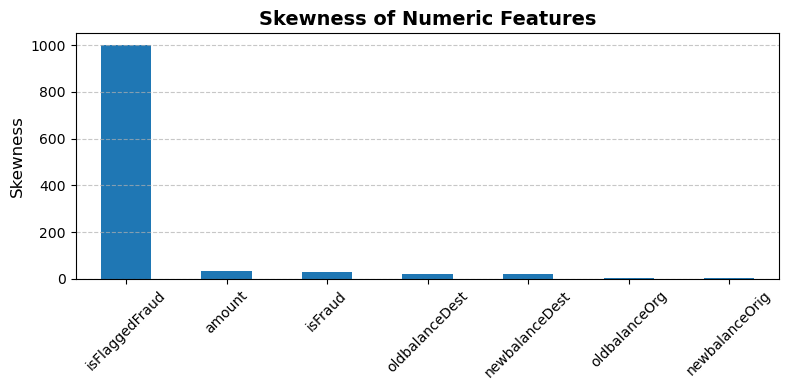

In [82]:
# Select clean numeric columns
numeric_cols= transactions_cleaned.select_dtypes(include=['number']).columns

# Calculate skewness for each numeric column (without lambda)
skewness = transactions_cleaned[numeric_cols].skew().sort_values(ascending=False)

print("Skewness of Numeric Features:", skewness)

# Optional: visualize skewness with a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
skewness.plot(kind='bar')
plt.title('Skewness of Numeric Features', fontsize=14, fontweight='bold')
plt.ylabel('Skewness', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Interprettaion:** In this dataset, almost every numeric feature is **heavily right-skewed**:
- `isFlaggedFraud` shows extreme skew (1000+) because it is a **binary column** with nearly all values as 0 (non-flagged). This column does not need transformation, as it is not continuous.
- Features like `amount`, `isFraud`, and the balance columns also have large positive skew due to the **rare but very large transactions** as shown in the EDA notebook.

Since highly skewed continuous features can **hurt model performance** (especially for algorithms sensitive to distribution, like logistic regression), we will **apply log transformations** to these continuous variables in the next step.  

Binary variables such as `isFraud` and `isFlaggedFraud` will be left as is.

**Why Use Log Transformations?**

Some of the number columns in this dataset (like transaction amounts and balances) have **very big values compared to most others**. Most transactions are small or moderate, but a few are extremely large, which makes the data **skewed** (heavily stretched to one side).

When data is this skewed:  
- It can make it harder for models to learn correctly.  
- The very large numbers can overpower the smaller ones, making it harder to spot normal patterns.  

To fix this, we use a **log transformation**. This shrinks the biggest numbers while keeping the order of the values the same, so the data is more balanced and easier for models to work with.

We will only transform the **continuous number columns** (like amounts and balances). Columns that are yes/no flags (like `isFraud` or `isFlaggedFraud`) will not be changed because they don’t need it.

The transformation uses `log(x + 1)` so that:
- Values of 0 (or very small numbers) do not cause errors, since `log(0)` is undefined.
- Large numbers are shrunk down while still keeping their order (larger amounts remain larger than smaller amounts).


In [83]:
# Identify continuous numeric columns (skip fraud flags)
continuous_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                   'oldbalanceDest', 'newbalanceDest']

# Apply log transformation (log(x+1) to handle zeros)
transactions_transformed = transactions_cleaned.copy()
for col in continuous_cols:
    transactions_transformed[col] = np.log(transactions_transformed[col] + 1)

# Show first few rows to confirm the transformation
transactions_transformed[continuous_cols].head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,6.891717,10.511383,10.484254,0.000000,0.000000
1,10.919013,11.507058,10.696474,0.000000,0.000000
2,12.305859,15.866177,15.894210,13.736503,13.463178
3,14.673068,0.000000,0.000000,15.251210,15.696498
4,11.127133,0.000000,0.000000,13.346016,13.449230


The log transformation changes the distribution of the continuous features. Before transformation, each feature showed a **heavily right-skewed shape** where a few extremely large values stretched the scale and made most of the data cluster near zero.  

After applying `log(x + 1)`:
- The scale of the largest values is compressed, reducing the dominance of extreme transactions.
- The overall distribution becomes **more balanced**, making these features easier for models to interpret.
- The order of values remains the same (larger amounts are still larger), but the relative differences between extreme values and typical ones are smaller.

This transformation helps prevent extreme values from overpowering smaller ones in the modeling stage while preserving the information these features carry.

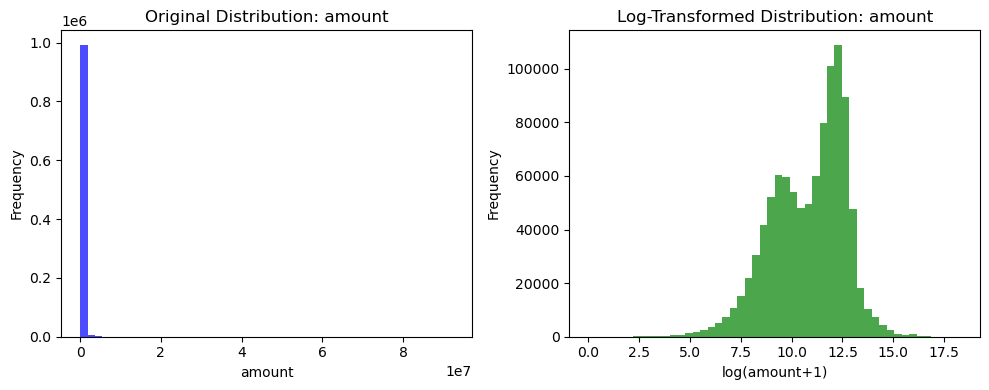

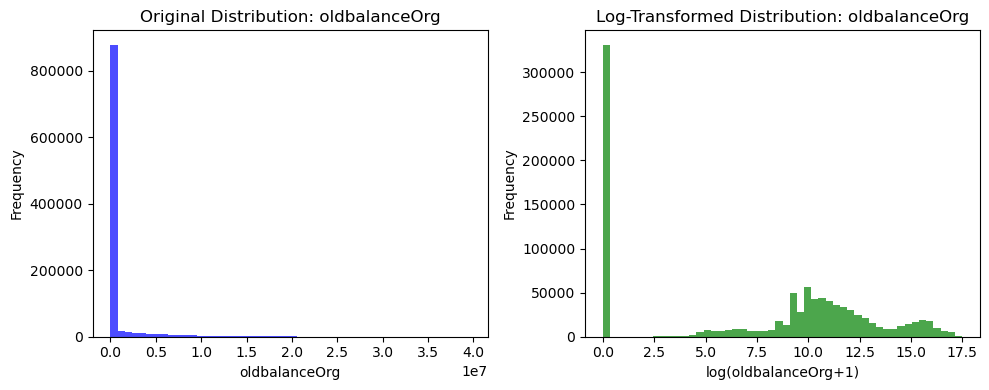

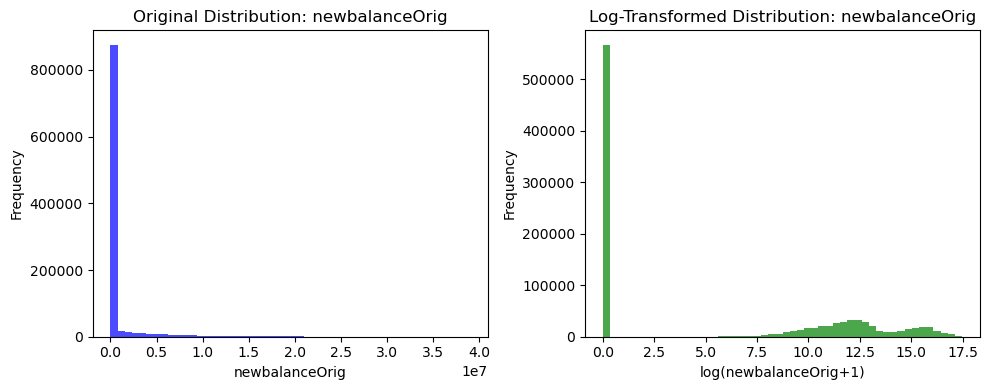

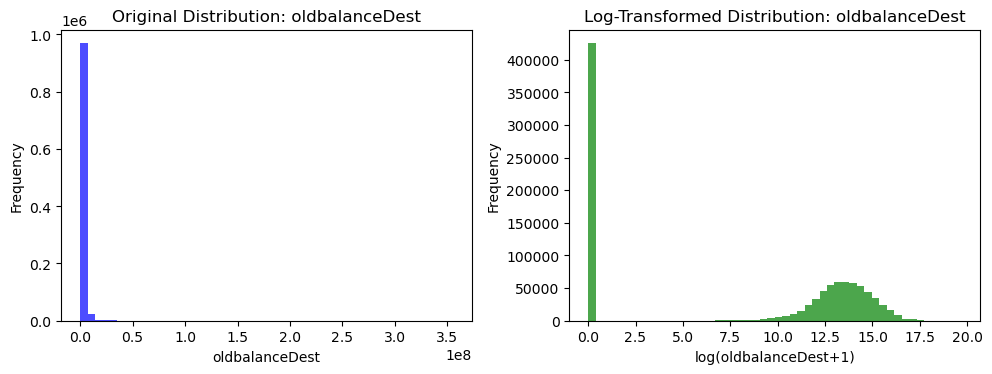

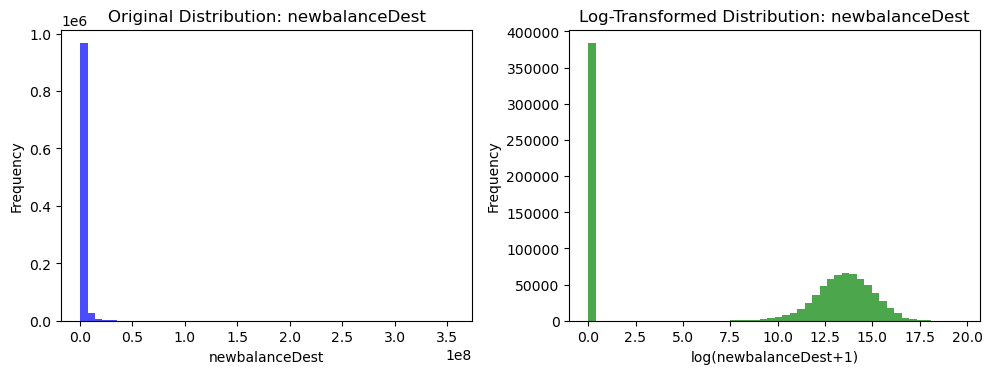

In [84]:
# Plot histograms for each transformed column (before vs. after)
for col in continuous_cols:
    plt.figure(figsize=(10, 4))
    
    # Original data
    plt.subplot(1, 2, 1)
    plt.hist(transactions_cleaned[col], bins=50, color='blue', alpha=0.7)
    plt.title(f"Original Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    
    # Log-transformed data
    plt.subplot(1, 2, 2)
    plt.hist(transactions_transformed[col], bins=50, color='green', alpha=0.7)
    plt.title(f"Log-Transformed Distribution: {col}")
    plt.xlabel(f"log({col}+1)")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()


**Encoding the Transaction Type Column**

The `type` column is a categorical feature that indicates the kind of transaction (`CASH_OUT`, `TRANSFER`, etc.). Most machine learning models cannot use text categories directly, so this feature must be **converted into numeric format**. To avoid creating a single ordered number (which would incorrectly imply a ranking), we will use **one-hot encoding**. This creates a new column for each transaction type, where each row has a `1` for its transaction type and `0` for all others.


In [85]:
# Create dummy variables separately
type_dummies = pd.get_dummies(transactions_transformed['type'])

# Combine the dummy columns with the main dataset
transactions_encoded = pd.concat([transactions_transformed.drop(columns=['type']), type_dummies], axis=1)

# Display the first few rows of the encoded dataset
transactions_encoded.head()


,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,6.891717,10.511383,10.484254,M1491308340,0.000000,0.000000,0,0,False,False,False,True,False
1,10.919013,11.507058,10.696474,M2102868029,0.000000,0.000000,0,0,False,False,False,True,False
2,12.305859,15.866177,15.894210,C1339195526,13.736503,13.463178,0,0,True,False,False,False,False
3,14.673068,0.000000,0.000000,C620979654,15.251210,15.696498,0,0,False,False,False,False,True
4,11.127133,0.000000,0.000000,C142246322,13.346016,13.449230,0,0,False,True,False,False,False


The `type` column was converted into separate columns using one-hot encoding. Each new column represents a transaction type (`CASH_OUT`, `TRANSFER`, `PAYMENT`, etc.). For each transaction, a `1` indicates its type, while all other type columns remain `0`.

The original `type` column was removed, and the new dummy variables were added to the dataset. This format allows machine learning models to use the transaction type information without treating the categories as a ranked or continuous variable.

**Answer**

The numeric features (`amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`) were log transformed using `log(x + 1)` to reduce skew caused by rare, extremely large transactions. The `type` column was one-hot encoded, creating separate indicator columns for each transaction type while removing the original categorical column.  

These transformations prepare the dataset for modeling by ensuring that:
- Continuous features are on a more balanced scale.
- The categorical transaction types are represented numerically without implying any order.

## Q3

Now that the dataset is cleaned, scaled, and the `type` column has been encoded, the next step is to **get it ready for modeling** by fixing the imbalance between fraud and non-fraud cases and creating any helpful new features.

Fraudulent transactions make up only a tiny part of the data.  
If left this way, most models will predict everything as "not fraud" because that will be correct almost all the time.  
To make sure the model learns to spot fraud, we will:
- Check how many fraud vs. non-fraud cases there are.
- Balance the data (using oversampling, undersampling, or SMOTE).
- Add new features, based on what was learned in EDA, to make it easier for the model to tell fraud apart from normal transactions.

The following is being addressed, 

    After exploring your data, you may have noticed that fraudulent transactions are rare compared to non-fraudulent ones. What challenges might this pose when training a machine learning model? What strategies could you use to ensure your model learns meaningful patterns from the minority class? Apply your data transformations (if any) in the code-block below.


**Why Class Imbalance Matters**

Fraud cases are rare in this dataset, making up only a small fraction of all transactions as shown in the EDA. If this imbalance is not addressed, most models will simply predict "not fraud" for every transaction because that will be correct the vast majority of the time. While this would give a high accuracy score, it would fail to detect fraudulent activity, which is the main goal.

The first step is to measure the imbalance by comparing the number of fraud and non-fraud transactions.


In [86]:
# Count fraud vs. non-fraud cases
class_counts = transactions_encoded['isFraud'].value_counts()

print("Class Distribution:", class_counts)

Class Distribution: isFraud
0    998703
1      1297
Name: count, dtype: int64


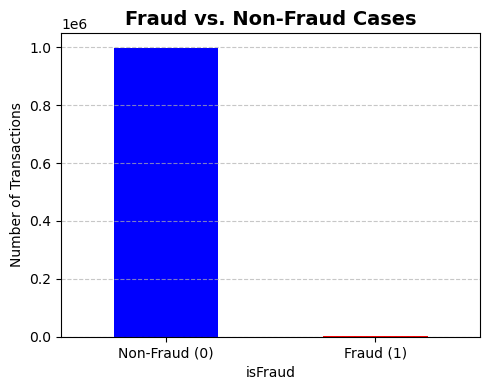

In [87]:
# Plot bar chart for class distribution
plt.figure(figsize=(5, 4))
class_counts.plot(kind='bar', color=['blue', 'red'])
plt.title("Fraud vs. Non-Fraud Cases", fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.ylabel("Number of Transactions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Interpretation:** The dataset is **extremely imbalanced**:  
- **998,703 transactions (99.87%) are non-fraudulent.**  
- **Only 1,297 transactions (0.13%) are fraudulent.**

This imbalance means that, without adjustments, a model could predict "non-fraud" for every transaction and still achieve nearly **99.9% accuracy** but it would completely fail to identify fraudulent activity. To build a useful model, the fraud class will need to be handled carefully (via **oversampling, undersampling, or synthetic data generation like SMOTE**) so that the model can learn to recognize fraudulent patterns despite their rarity.


In [88]:
# Random Oversampling 

# Check current class counts
print("Before balancing:", transactions_encoded['isFraud'].value_counts())

# Split fraud and non-fraud into two separate DataFrames
fraud_cases = transactions_encoded[transactions_encoded['isFraud'] == 1]
nonfraud_cases = transactions_encoded[transactions_encoded['isFraud'] == 0]

# Oversample fraud to match non-fraud
fraud_upsampled = fraud_cases.sample(n=len(nonfraud_cases), replace=True, random_state=42)

# Combine back into one balanced dataset
transactions_balanced = pd.concat([nonfraud_cases, fraud_upsampled])

# Shuffle the rows so it’s mixed
transactions_balanced = transactions_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check class counts after balancing
print("After balancing:", transactions_balanced['isFraud'].value_counts())


Before balancing: isFraud
0    998703
1      1297
Name: count, dtype: int64
After balancing: isFraud
1    998703
0    998703
Name: count, dtype: int64


In [89]:
# SMOTE

# Separate features (X) and target (y), and drop 'nameDest' (non-numeric)
X = transactions_encoded.drop(columns=['isFraud', 'nameDest'])
y = transactions_encoded['isFraud']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine back into one balanced DataFrame
transactions_balanced_smote = pd.concat(
    [pd.DataFrame(X_resampled, columns=X.columns), 
     pd.Series(y_resampled, name='isFraud')], axis=1
)

# Check the new class counts
print("After SMOTE balancing:")
print(transactions_balanced_smote['isFraud'].value_counts())


After SMOTE balancing:
isFraud
0    998703
1    998703
Name: count, dtype: int64


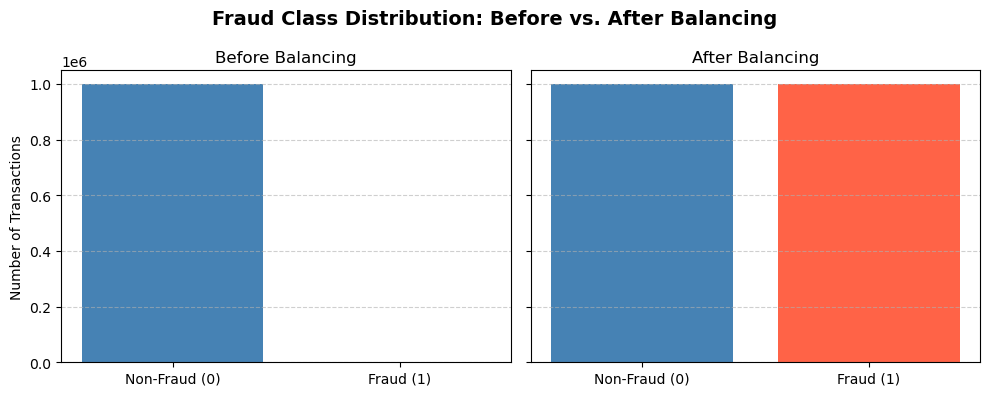

In [90]:

# Class counts before and after balancing
before_counts = transactions_encoded['isFraud'].value_counts()
after_counts = transactions_balanced['isFraud'].value_counts()

# Plot side-by-side bar chart
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].bar(['Non-Fraud (0)', 'Fraud (1)'], before_counts, color=['steelblue', 'tomato'])
axes[0].set_title('Before Balancing')
axes[0].set_ylabel('Number of Transactions')

axes[1].bar(['Non-Fraud (0)', 'Fraud (1)'], after_counts, color=['steelblue', 'tomato'])
axes[1].set_title('After Balancing')

for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Fraud Class Distribution: Before vs. After Balancing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation:** To fix the imbalance, two approaches were tested:

1. **Random Oversampling** – Existing fraud cases were randomly duplicated until the fraud class matched the size of the non-fraud class (998,703 each). This is simple but can lead to overfitting, since many duplicate rows are introduced.

2. **SMOTE (Synthetic Minority Oversampling Technique)** – Instead of duplicating rows, SMOTE creates **new, synthetic fraud examples** by interpolating between similar fraud cases.  This helps reduce overfitting and can improve generalization but may create unrealistic synthetic points if the fraud class is very sparse.

After balancing, both classes now contain **998,703 rows**, resulting in a **balanced dataset** ready for modeling. Balancing ensures that the fraud class is not ignored and allows models to learn patterns that distinguish fraudulent from legitimate transactions.

**Answer**

The dataset was balanced by **oversampling** the fraud cases so that both classes contain **998,703 transactions**. This adjustment prevents the model from ignoring fraudulent transactions and ensures both classes are equally represented for training.

## Bonus (optional)

Are there interaction effects between variables (e.g., fraud and high amount and transaction type) that aren't captured directly in the dataset? Would it be helpful to manually engineer any new features that reflect these interactions? Apply your data transformations (if any) in the code-block below.

Answer Here

In [91]:
# write out newly transformed dataset to your folder

# Create 'processed_data' inside the existing 'data' folder (if it doesn't already exist)
os.makedirs('data/processed_data', exist_ok=True)

# Save both balanced datasets
transactions_balanced.to_csv('data/processed_data/transactions_balanced_random.csv', index=False)
transactions_balanced_smote.to_csv('data/processed_data/transactions_balanced_smote.csv', index=False)

print("Both datasets exported into 'data/processed_data':")
print("- data/processed_data/transactions_balanced_random.csv")
print("- data/processed_data/transactions_balanced_smote.csv")

Both datasets exported into 'data/processed_data':
- data/processed_data/transactions_balanced_random.csv
- data/processed_data/transactions_balanced_smote.csv
